In [1]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/gan-getting-started.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [2]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.1 MB/s eta 0:00:00


#### Import Libraries

In [3]:
import tensorflow as tf
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,LeakyReLU,Concatenate,Activation,Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


##### Load Data

In [4]:
img_dir = "/content/photo_jpg/"
img_size = (256,256)
monet_dir = "/content/monet_jpg/"

In [41]:
# Get all image file names
image_path = [file for file in os.listdir(img_dir) if file.endswith(".jpg")]
monet_path = [file for file in os.listdir(monet_dir) if file.endswith(".jpg")]

In [44]:
#dataset for test
image_test = image_path[300:310]

In [45]:
image_path = image_path[:300]
monet_path = monet_path[:300]

In [7]:
img_list = []
monet_list = []

In [8]:
def load_data(img_dir,monet_dir):
  for i in range(len(image_path)):
    img = cv2.imread(img_dir + image_path[i])
    img = cv2.resize(img,img_size)
    #scale the values between -1 and 1
    img = (img - 127.5) / 127.5
    img = img.astype(np.float32)

    monet = cv2.imread(monet_dir + monet_path[i])
    monet = cv2.resize(monet,img_size)
    #scale the values between -1 and 1
    monet = (monet - 127.5) / 127.5
    monet = monet.astype(np.float32)

    img_list.append(img)
    monet_list.append(monet)

  return np.array(monet_list),np.array(img_list)

In [9]:
#Load Data
monet,img = load_data(img_dir,monet_dir)

In [10]:
dataset = [monet,img]

#### Custom Functions to help build the final Model

In [12]:
def generate_real_samples(dataset,n_samples,patch_shape):
  ix = np.random.randint(0,dataset.shape[0],n_samples)
  X = dataset[ix]
  # All Y values are 1 to denote real images
  y = np.ones((n_samples,patch_shape,patch_shape,1))
  return X,y

In [13]:
def generate_fake_samples(g_model,dataset,patch_size):
  X = g_model.predict(dataset)
  # All Y values are 0 to denote fake images
  y = np.zeros((len(X),patch_size,patch_size,1))
  return X,y

In [14]:
def define_discriminator(input_shape):
  # Kenel initializer value as per paper
  # Use Instance Normalisation
  # Leaky relu with alpha as 0.2
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=input_shape)

  d = Conv2D(64, (4,4), padding='same', kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)

  model = Model(in_image, patch_out)

  # Parameters defined as per paper
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
  return model

In [15]:
#Residual layer
def resnet_block(n_filters, input_layer):
  init = RandomNormal(stddev=0.02)

  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)

  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)

  g = Concatenate()([g, input_layer])

  return g

In [16]:
#Architecture defined as per paper
# 7x7 Patch GAN
def define_generator(image_shape=(256,256,3)):

  init = RandomNormal(stddev=0.02)

  in_image = Input(shape=image_shape)

  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g = Activation('relu')(g)

  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)

  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)

  for i in range(9):
    g = resnet_block(256, g)

  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)

  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)

  g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g = Activation('tanh')(g)

  model = Model(in_image, g)
  return model

In [17]:
#We maintain a image Pool of size 50 from which the image will be fed to the discriminator
def update_imagePool(pool,images,max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
      pool.append(image)
      selected.append(image)
    #when the pool size is max then we take 50-50 chance between choosing from the pool or the received array
    elif np.random.random() > 0.5:
      ix = np.random.randint(0,len(pool))
      selected.append(pool[ix])
      pool[ix] = image
    else:
      selected.append(image)

  return np.asarray(selected)

In [18]:
# Training model for generator , here g_model1 is to be trained and the others are made non-trainable
def composite_model(g_model1,g_model2,d_model,image_shape):

  g_model1.trainable = True

  g_model2.trainable = False
  d_model.trainable = False

  #Adversarialloss
  input_gen = Input(shape=image_shape)
  gen1_out = g_model1(input_gen)
  output_d = d_model(gen1_out)

  #Identityloss
  input_id = Input(shape=image_shape)
  output_id = g_model1(input_id)
  print("Shape of gen1_out:", gen1_out.shape)

  #Cycleloss forward
  output_f = g_model2(gen1_out)

  #Cycleloss backward
  gen2_out = g_model2(input_id)
  print("Shape of gen2_out:", gen2_out.shape)
  output_b = g_model1(gen2_out)

  model = Model(inputs=[input_gen,input_id],outputs=[output_d,output_id,output_f,output_b])

  opt = Adam(learning_rate=0.0002, beta_1=0.5)

  model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],optimizer=opt)

  return model

In [19]:
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save('model/'+filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save('/content/model'+filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [20]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig('/content/images/'+filename1)
	plt.close()

In [21]:
def train(d_modelA,d_modelB,g_modelAtoB,g_modelBtoA,c_modelAtoB,c_modelBtoA,dataset,epochs=30):
    poolA,poolB = list(),list()

    n_epochs, n_batch = epochs, 1 #batch size 1 as in paper

    trainA, trainB = dataset

    bat_per_epo = int(len(trainA) / n_batch)

    n_steps = bat_per_epo * n_epochs

    patch_size = d_modelA.output_shape[1]
    for i in range(n_steps):
          XrealA, YrealA = generate_real_samples(trainA,n_batch,patch_size)
          XrealB, YrealB = generate_real_samples(trainB,n_batch,patch_size)

          XfakeA, YfakeA = generate_fake_samples(g_modelBtoA,XrealB,patch_size)
          XfakeB, YfakeB = generate_fake_samples(g_modelAtoB,XrealA,patch_size)

          XfakeA = update_imagePool(poolA, XfakeA)
          XfakeB = update_imagePool(poolB, XfakeB)

          # update generator B->A via the composite model
          g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([XrealB, XrealA], [YrealA, XrealA, XrealB, XrealA])
          # update discriminator for A -> [real/fake]
          dA_loss1 = d_model_A.train_on_batch(XrealA, YrealA)
          dA_loss2 = d_model_A.train_on_batch(XfakeA, YfakeA)

          # update generator A->B via the composite model
          g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([XrealA, XrealB], [YrealB, XrealB, XrealA, XrealB])
          # update discriminator for B -> [real/fake]
          dB_loss1 = d_model_B.train_on_batch(XrealB, YrealB)
          dB_loss2 = d_model_B.train_on_batch(XfakeB, YfakeB)

          print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

          if (i+1) % (bat_per_epo * 5) == 0:
			        save_models(i, g_model_AtoB, g_model_BtoA)
          if (i+1) % (bat_per_epo * 1) == 0:
              # plot A->B translation
              summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
              # plot B->A translation
              summarize_performance(i, g_model_BtoA, trainB, 'BtoA')




In [22]:
image_shape = dataset[0].shape[1:]
image_shape

(256, 256, 3)

#### Define models using the functions above

In [23]:
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = composite_model(g_model_AtoB,g_model_BtoA, d_model_B , image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = composite_model(g_model_BtoA,g_model_AtoB, d_model_A, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Shape of gen1_out: (None, 256, 256, 3)
Shape of gen2_out: (None, 256, 256, 3)
Shape of gen1_out: (None, 256, 256, 3)
Shape of gen2_out: (None, 256, 256, 3)


#### Train model

In [25]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=15)

1/1 [==============================] - 0s 23ms/step
Iteration>1, dA[0.013,0.048] dB[0.005,0.166] g[6.582,6.716]
1/1 [==============================] - 0s 23ms/step
Iteration>2, dA[0.005,0.344] dB[0.232,0.199] g[4.691,5.009]
1/1 [==============================] - 0s 23ms/step
Iteration>3, dA[0.210,0.064] dB[0.248,0.028] g[6.584,6.891]
1/1 [==============================] - 0s 23ms/step
Iteration>4, dA[0.013,0.068] dB[0.170,0.068] g[8.941,8.999]
1/1 [==============================] - 0s 22ms/step
Iteration>5, dA[0.027,0.200] dB[0.138,0.189] g[6.335,6.106]
1/1 [==============================] - 0s 31ms/step
Iteration>6, dA[0.169,0.073] dB[0.230,0.127] g[5.697,6.500]
1/1 [==============================] - 0s 36ms/step
Iteration>7, dA[0.005,0.044] dB[0.042,0.194] g[6.837,8.873]
1/1 [==============================] - 0s 21ms/step
Iteration>8, dA[0.008,0.149] dB[0.216,0.066] g[5.321,5.935]
1/1 [==============================] - 0s 81ms/step
Iteration>9, dA[0.028,0.077] dB[0.155,0.094] g[7.948

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Iteration>1500, dA[0.000,0.000] dB[0.045,0.046] g[3.198,4.356]


>Saved: g_model_AtoB_001500.h5 and g_model_BtoA_001500.h5
1/1 [==============================] - 0s 22ms/step
Iteration>1501, dA[0.000,0.000] dB[0.023,0.063] g[4.730,5.163]
1/1 [==============================] - 0s 22ms/step
Iteration>1502, dA[0.000,0.000] dB[0.089,0.014] g[4.179,4.993]
1/1 [==============================] - 0s 23ms/step
Iteration>1503, dA[0.000,0.000] dB[0.180,0.133] g[4.847,5.937]
1/1 [==============================] - 0s 22ms/step
Iteration>1504, dA[0.000,0.000] dB[0.063,0.060] g[5.032,6.033]
1/1 [==============================] - 0s 34ms/step
Iteration>1505, dA[0.000,0.000] dB[0.011,0.231] g[4.251,5.753]
1/1 [==============================] - 0s 35ms/step
Iteration>1506, dA[0.000,0.000] dB[0.021,0.046] g[3.651,4.315]
1/1 [==============================] - 0s 23ms/step
Iteration>1507, dA[0.000,0.000] dB[0.320,0.093] g[5.318,6.245]
1/1 [==============================] - 0s 21ms/step
Iteration>1508, dA[0.000,0.000] dB[0.126,0.067] g[4.106,4.552]
1/1 [=================

Iteration>3000, dA[0.207,0.153] dB[0.016,0.325] g[3.948,4.546]


>Saved: g_model_AtoB_003000.h5 and g_model_BtoA_003000.h5
1/1 [==============================] - 0s 23ms/step
Iteration>3001, dA[0.134,0.008] dB[0.124,0.343] g[4.298,5.374]
1/1 [==============================] - 0s 23ms/step
Iteration>3002, dA[0.032,0.052] dB[0.212,0.003] g[3.517,3.416]
1/1 [==============================] - 0s 22ms/step
Iteration>3003, dA[0.000,0.188] dB[0.058,0.033] g[3.341,2.968]
1/1 [==============================] - 0s 35ms/step
Iteration>3004, dA[0.030,0.076] dB[0.004,0.004] g[2.455,3.365]
1/1 [==============================] - 0s 25ms/step
Iteration>3005, dA[0.057,0.006] dB[0.032,0.048] g[3.262,4.388]
1/1 [==============================] - 0s 22ms/step
Iteration>3006, dA[0.026,0.014] dB[0.086,0.005] g[3.183,3.619]
1/1 [==============================] - 0s 23ms/step
Iteration>3007, dA[0.001,0.002] dB[0.039,0.403] g[3.411,4.193]
1/1 [==============================] - 0s 23ms/step
Iteration>3008, dA[0.003,0.024] dB[0.008,0.156] g[2.705,3.764]
1/1 [=================

KeyboardInterrupt: 

#### Load trained model

In [26]:

lmodel = tf.keras.models.load_model('/content/drive/MyDrive/gan-getting-started/model/g_model_AtoB_004500.h5')

In [30]:
len(dataset)

2

In [47]:
test_img = []

In [48]:
for i in range(len(image_test)):
    img = cv2.imread(img_dir + image_test[i])
    img = cv2.resize(img,img_size)
    #scale the values between -1 and 1
    img = (img - 127.5) / 127.5
    img = img.astype(np.float32)

    test_img.append(img)

In [49]:
test_img = np.array(test_img)

In [50]:
len(test_img)

10

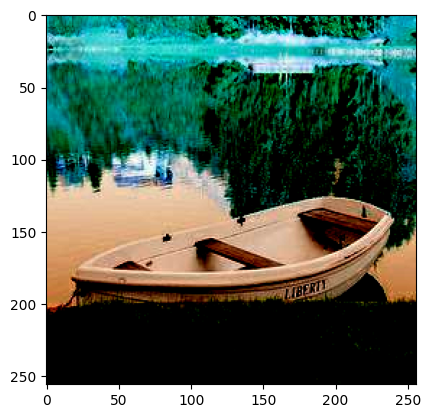

In [64]:
plt.imshow(test_img[6])

In [65]:
monet_Test = lmodel.predict(test_img)

1/1 [==============================] - 0s 30ms/step


In [66]:
monet_Test = (monet_Test + 1) / 2.0

#### Final Result

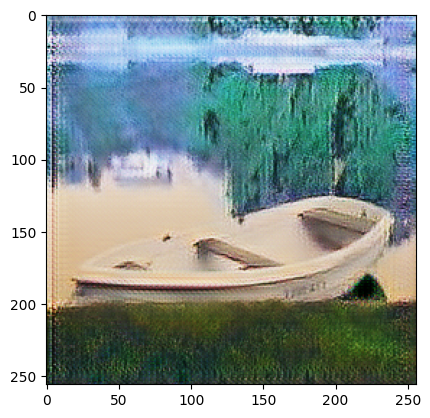

In [67]:
plt.imshow(monet_Test[6])